<h1>ICASSP2019 Tutorial:<br> Detection and Classification of Acoustic Scenes and Events</h1>

<div class="row">
    <div class="col-md-2">
        <img src="http://www.cs.tut.fi/~heittolt/images/toni_heittola.png" class="img-circle" style="height:100px;width:100px;">
    </div>
    <div class="col-md-10">
        <strong>Author</strong><br>
        Toni Heittola<br>
        <a href="http://arg.cs.tut.fi/" target="_blank"><em>Audio Research Group / Tampere University</em></a><br>
        <a href="mailto:toni.heittola@tuni.fi" target="_blank"><i class="fa fa-1x fa-fw fa-envelope"></i></a>
        <a href="http://www.cs.tut.fi/~heittolt/" target="_blank"><i class="fa fa-1x fa-fw fa-home"></i></a>
        <a href="https://github.com/toni-heittola" target="_blank"><i class="fa fa-1x fa-fw fa-github"></i></a>
    </div>
</div>

In [14]:
%%html
<style>
.rise-enabled .rendered_html h1:first-child{margin-top: 0.2em;}
.rise-enabled .rendered_html h2:first-child{margin-top: 0.2em;}
.rise-enabled .rendered_html h3:first-child{margin-top: 0.2em;}
.rise-enabled .text_cell {font-size: 150%;}
.rise-enabled table{font-size:100%;}
.rise-enabled .reveal table th, .rise-enabled .reveal table td{border-bottom: transparent;}
.rise-enabled .reveal pre{font-size:120%;}
.rise-enabled .rendered_html p{margin-top:0.3em;margin-bottom:0.3em;}
.rise-enabled .rendered_html ul{margin-top:0.5em;}
.rise-enabled div.prompt {min-width: 5ex;width: 0px; min-width: 0px; visibility: collapse}
.rise-enabled div.output_subarea {padding-top: 0.2em;padding-bottom: 0.2em;max-width:100%;}
.rise-enabled div.text_cell_render{padding-top: 0.2em;padding-bottom: 0.2em;}
.rise-enabled pre, .rise-enabled code, .rise-enabled kbd, .rise-enabled samp {white-space: pre;}
</style>

<h1 class="text-muted">Sound classification with Python</h1>

This notebook demonstrates basic steps needed to build **CNN** based system.

**Acoustic scene classification** is used as an example application

Key tools used in this example:

- **`dcase_util`** &ndash; used to ease data handling
- **`keras`** &ndash; neural network API for fast experimentation used on top of **`tensorflow`** machine learning framework
- **`scikit-learn`** &ndash; set of machine learning tools, here used to evaluate the system output


Jupyter notebook: 
https://github.com/toni-heittola/icassp2019-tutorial

In [1]:
import dcase_util
from dcase_util.containers import AudioContainer
from dcase_util.features import MelExtractor
from dcase_util.data import ProbabilityEncoder
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_asc')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_asc.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_asc')):    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


# Outline

- Key Python tools used in this example
- Dataset
- Cross-validation set
- Acoustic features
- Learning stage
- Testing stage
- Evaluation

# Dataset

**`dcase_util`** implements dataset handling classes which can be used to access diffently organized dataset through uniform API:

- Download the dataset from the origin, e.g. zenodo.org
- Extract downloaded zip-packages and check data integrity 
- Access meta data (e.g. filter data based on scene labels)
- Access cross-validation sets bundled with the dataset

**TUT Urban Acoustic Scenes 2018** development dataset is used in this example:
- Recordings from 10 scene classes, 6 large european cities
- 5-6 minute recordings around selected locations, which were split into **10 seconds audio segments**

Dataset can be downloaded and accessed easily by using **dataset handler class** from `dcase_util`:

In [7]:
db = dcase_util.datasets.TUTUrbanAcousticScenes_2018_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [10]:
print('Audio file count :', len(db.audio_files))
print('Scene class count:', len(db.scene_labels()))

Audio file count : 8640
Scene class count: 10


In [17]:
db.scene_labels()

['airport',
 'bus',
 'metro',
 'metro_station',
 'park',
 'public_square',
 'shopping_mall',
 'street_pedestrian',
 'street_traffic',
 'tram']

Basic statistics of the dataset:

In [12]:
db.meta.show()

Scene label,Count,Identifiers
airport,864,22
bus,864,36
metro,864,29
metro_station,864,40
park,864,25
public_square,864,24
shopping_mall,864,22
street_pedestrian,864,28
street_traffic,864,25
tram,864,35


*Identifiers* are unique recording locations

In [12]:
# Single item
db.meta[3080]['identifier']

'barcelona-107'

In [13]:
# Identifiers for items with bus scene label
db.meta.filter(scene_label='street_traffic').unique_identifiers[0:6]

['barcelona-161',
 'barcelona-162',
 'barcelona-163',
 'barcelona-268',
 'helsinki-164',
 'helsinki-165']

## Important information about the dataset

- We need to be aware of recording location of each segment 
- Audio segments from the same location around the same time are **highly correlated**    
- Unrealistic to be able to train the system and test it with material recorded in same location only a few minutes apart
- Cross-validation set should take this into account in order to give realistic performance estimates

### Comparing segments from different recording locations

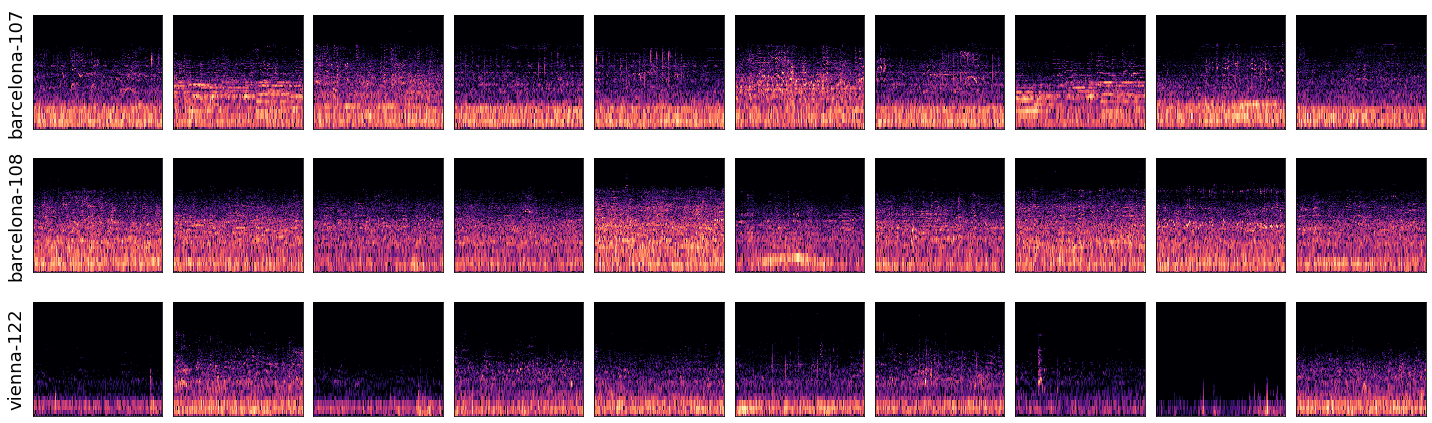

In [11]:
scene_label = scene_labels[5]
meta = db.meta.filter(scene_label=scene_label)
ids = meta.unique_identifiers
data = [meta.filter(identifier=ids[0]), meta.filter(identifier=ids[1]), meta.filter(identifier=ids[20])]
labels = [ids[0], ids[1], ids[20]]
example_c = 3
example_i = 10

fig, axes = plt.subplots(
    example_c,
    example_i,
    figsize=(example_i * 2, example_c * 2),
    sharex=True,
    sharey=True
)

fig.subplots_adjust(top=0.9, hspace=0.0, wspace=0.0)

for c in range(0, example_c):
    for i in range(0, example_i):
        item = data[c][i]
        plt.sca(axes[c, i])
        audio = dcase_util.containers.AudioContainer(filename=item['filename']).load(mono=True)
        audio.plot(plot_type='spec', plot=False, show_filename=False, hop_length=2048)
        axes[c, i].get_xaxis().set_visible(False)
        axes[c, i].set_yticklabels([])
        axes[c, i].tick_params(axis='both', which='both', length=0)
        if i == 0:
            axes[c, i].yaxis.label.set_visible(True)
            axes[c, i].set_ylabel(labels[c], fontsize=18)
        else:
            axes[c, i].yaxis.label.set_visible(False)
            axes[c, i].set_ylabel('')

plt.tight_layout()

- Segments from one location shows similar spectral patterns (comparing along rows)
- When comparing segments from different locations in same city (`barcelona-107` vs `barcelona-108`) or different city (`barcelona-107` vs `vienna-122`) similarities are not that prominent anymore

# Cross-validation set

- Dataset is released with a single **train/test**-split
- We need also a **validation set** to follow system performance on **unseen data**
- Dataset class can be used to split original training set into a new training set and validation set (70/30 split done according to recording locations):

- **Training set** is used to train the system
- **Testing set** is used to assess the performance of the fully trained system
- Split generated randomly while taking recording location into account. Location information stored in **identifier** field of each item in dataset

### Train/Test split bundled with the dataset

In [4]:
train_items = db.train(1).stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = db.train(1).stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        test_items,        
        train_items / (train_items + test_items) * 100.0,
        train_ids, 
        test_ids, 
        #train_ids / ( train_ids + test_ids)* 100.0,
    ],
    column_headers=['Scene label', 'Train set (items)', 'Test set (items)', 'Split percentage', 'Train (locations)', 'Test (locations)'],
    column_types=['str18', 'int', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=100
)

Scene label,Train set (items),Test set (items),Split percentage,Train (locations),Test (locations)
airport,599,265,69,15,7
bus,622,242,71,26,10
metro,603,261,69,20,9
metro_station,605,259,70,28,12
park,622,242,71,18,7
public_square,648,216,75,18,6
shopping_mall,585,279,67,16,6
street_pedestrian,617,247,71,20,8
street_traffic,618,246,71,18,7
tram,603,261,69,24,11


### Generating validation set

- During the training we need a **validation set** to follow system performance on **unseen data**
- Validation set can be extracted from the training set while taking location identifiers into account
- Dataset class can be used to generate validation set and a new training set:

In [13]:
training_files, validation_files = db.validation_split(
    validation_amount=0.3,                           # split target 30% 
    fold=1,   
    balancing_mode='identifier_two_level_hierarchy', # balance scene and locations
    disable_progress_bar=True
)

train_meta = db.train(1).filter(file_list=training_files)
validation_meta = db.train(1).filter(file_list=validation_files)


In [14]:
print('Training items  ', len(training_files))
print('Validation items', len(validation_files))

Training items   4134
Validation items 1988



### Train / Validation statistics

In [8]:
train_items = train_meta.stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = train_meta.stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

validation_items = validation_meta.stats()['scenes']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))
validation_ids = validation_meta.stats()['scenes']['identifiers']
validation_ids = numpy.append(validation_ids, numpy.sum(validation_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_ids, 
        validation_ids, 
        validation_ids / ( train_ids + validation_ids)* 100.0,
        #test_ids,         

        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items,        

    ],
    column_headers=['Scene label', 
                    'Train (locations)', 'Validation (locations)', 'Split percentage', 
                    #'Test (locations)',
                    'Train set (items)', 'Validation set (items)', 'Split percentage', 
                    #'Test set (items)',
                   
                   ],
    column_types=['str17', 'int', 'int', 'float1', 'int', 'int', 'float1', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=110
)

Scene label,Train (locations),Validation (locations),Split percentage,Train set (items),Validation set (items),Split percentage
airport,9,6,40.0,411,188,31.4
bus,16,10,38.5,413,209,33.6
metro,13,7,35.0,422,181,30.0
metro_station,18,10,35.7,408,197,32.6
park,12,6,33.3,425,197,31.7
public_square,12,6,33.3,433,215,33.2
shopping_mall,10,6,37.5,360,225,38.5
street_pedestrian,13,7,35.0,422,195,31.6
street_traffic,12,6,33.3,425,193,31.2
tram,16,8,33.3,415,188,31.2


# Acoustic features - log-mel energies

Feature extractor initialized with parameters and used to extract features:

In [15]:
audio = dcase_util.containers.AudioContainer().load(
    filename=db.audio_files[0], 
    mono=True
)
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04, 
    hop_length_seconds=0.02, 
    fs=audio.fs
)
mel_data = mel_extractor.extract(
    y=audio
)
mel_data.shape

(40, 501)

# Learning acoustic model

For each learning example, we need to have:

1) **Feature matrix**

In [16]:
# Load audio
audio = dcase_util.containers.AudioContainer().load(
    filename=train_meta[0].filename, mono=True
)

# Extract log-mel energies
sequence_length = 500        # 10s / 0.02s = 500
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs
)
features = mel_extractor.extract(audio.data)[:,:sequence_length]

In [17]:
print('features shape', '(frequency, time)', features.shape)

features shape (frequency, time) (40, 500)


### Feature matrix visualized

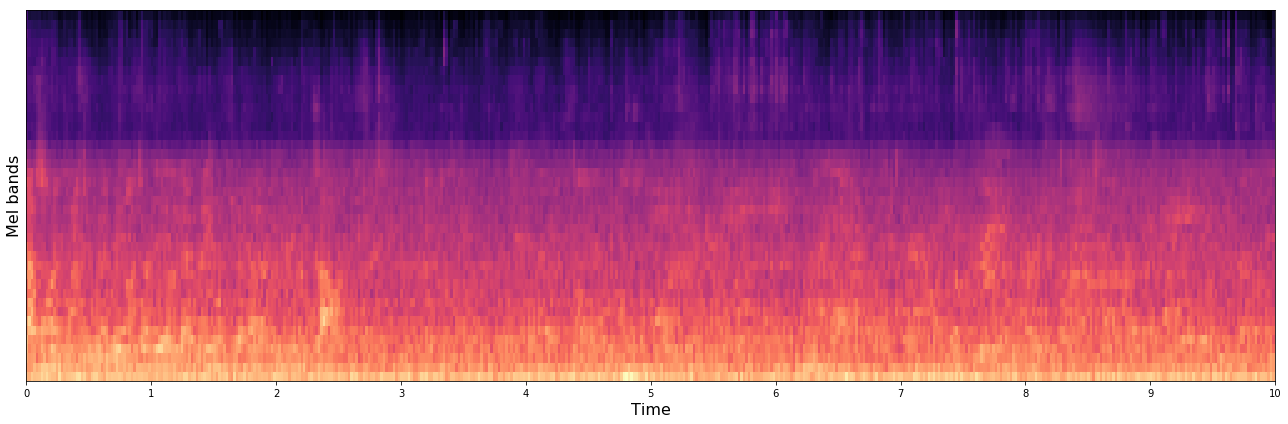

In [12]:
dcase_util.containers.FeatureContainer(
    data=features,
    time_resolution=mel_extractor.hop_length_seconds
).plot(
    ylabel='Mel bands',
    xlabel='Time',
    figsize=(18,6)
)

2) **Target vector** (one-hot encoded vector)

In [18]:
# List of scene labels
scene_labels = db.scene_labels()               

# Empty target vector
target_vector = numpy.zeros(len(scene_labels))      

# Place one at correct position 
target_vector[scene_labels.index(train_meta[0].scene_label)] = 1   
target_vector 

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
print('target vector shape', '(classes, )', target_vector.shape)

target vector shape (classes, ) (10,)


## Collect training data

In [20]:
X_train = []
Y_train = []
for item in train_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_train.append(features) 
    Y_train.append(target_vector)
    
X_train = numpy.moveaxis(numpy.dstack(X_train), 2, 0)
Y_train = numpy.vstack(Y_train)
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/airport-barcelona-1-16-a.wav
Load audio/airport-barcelona-1-17-a.wav
Load audio/airport-barcelona-1-18-a.wav
Load audio/airport-barcelona-1-19-a.wav
Load audio/airport-barcelona-1-20-a.wav
Load audio/airport-barcelona-1-21-a.wav
Load audio/airport-barcelona-1-22-a.wav
Load audio/airport-barcelona-1-23-a.wav
Load audio/airport-barcelona-1-24-a.wav
Load audio/airport-barcelona-1-25-a.wav
Load audio/airport-barcelona-1-26-a.wav
Load audio/airport-barcelona-1-27-a.wav
Load audio/airport-barcelona-1-28-a.wav
Load audio/airport-barcelona-1-29-a.wav
Load audio/airport-barcelona-1-30-a.wav
Load audio/airport-barcelona-1-31-a.wav
Load audio/airport-barcelona-1-32-a.wav
Load audio/airport-barcelona-1-33-a.wav
Load audio/airport-barcelona-1-34-a.wav
Load audio/airport-barcelona-1-35-a.wav
Load audio/airport-barcelona-1-36-a.wav
Load audio/airport-barcelona-1-37-a.wav
Load audio/airport-barcelona-1-38-a.wav
Load audio/airport-barcelona-1-39-a.wav
Load audio/airport-barcelona-1-40-a.wav


Load audio/airport-paris-7-350-a.wav
Load audio/airport-paris-7-351-a.wav
Load audio/airport-paris-7-352-a.wav
Load audio/airport-paris-9-371-a.wav
Load audio/airport-paris-9-372-a.wav
Load audio/airport-paris-9-373-a.wav
Load audio/airport-paris-9-374-a.wav
Load audio/airport-paris-9-375-a.wav
Load audio/airport-paris-9-376-a.wav
Load audio/airport-paris-9-377-a.wav
Load audio/airport-paris-9-378-a.wav
Load audio/airport-paris-9-379-a.wav
Load audio/airport-paris-9-380-a.wav
Load audio/airport-paris-9-381-a.wav
Load audio/airport-paris-9-382-a.wav
Load audio/airport-paris-9-383-a.wav
Load audio/airport-paris-9-384-a.wav
Load audio/airport-paris-9-385-a.wav
Load audio/airport-paris-9-386-a.wav
Load audio/airport-paris-9-387-a.wav
Load audio/airport-paris-9-388-a.wav
Load audio/airport-paris-9-389-a.wav
Load audio/airport-paris-9-390-a.wav
Load audio/airport-paris-9-391-a.wav
Load audio/airport-paris-9-392-a.wav
Load audio/airport-paris-9-393-a.wav
Load audio/airport-paris-9-394-a.wav
L

Load audio/bus-helsinki-18-721-a.wav
Load audio/bus-helsinki-18-722-a.wav
Load audio/bus-helsinki-18-723-a.wav
Load audio/bus-helsinki-18-724-a.wav
Load audio/bus-helsinki-18-725-a.wav
Load audio/bus-helsinki-18-726-a.wav
Load audio/bus-helsinki-18-727-a.wav
Load audio/bus-helsinki-18-728-a.wav
Load audio/bus-helsinki-18-729-a.wav
Load audio/bus-helsinki-18-730-a.wav
Load audio/bus-helsinki-18-731-a.wav
Load audio/bus-helsinki-18-732-a.wav
Load audio/bus-helsinki-18-733-a.wav
Load audio/bus-helsinki-18-734-a.wav
Load audio/bus-helsinki-18-735-a.wav
Load audio/bus-helsinki-18-736-a.wav
Load audio/bus-helsinki-18-737-a.wav
Load audio/bus-helsinki-18-738-a.wav
Load audio/bus-helsinki-18-739-a.wav
Load audio/bus-helsinki-18-740-a.wav
Load audio/bus-helsinki-18-741-a.wav
Load audio/bus-helsinki-18-742-a.wav
Load audio/bus-helsinki-19-743-a.wav
Load audio/bus-helsinki-19-744-a.wav
Load audio/bus-helsinki-19-745-a.wav
Load audio/bus-helsinki-19-746-a.wav
Load audio/bus-helsinki-19-747-a.wav
L

Load audio/bus-vienna-38-1123-a.wav
Load audio/bus-vienna-38-1124-a.wav
Load audio/bus-vienna-38-1125-a.wav
Load audio/bus-vienna-38-1126-a.wav
Load audio/bus-vienna-38-1127-a.wav
Load audio/bus-vienna-38-1128-a.wav
Load audio/bus-vienna-38-1129-a.wav
Load audio/bus-vienna-38-1130-a.wav
Load audio/bus-vienna-38-1131-a.wav
Load audio/bus-vienna-38-1132-a.wav
Load audio/bus-vienna-38-1133-a.wav
Load audio/bus-vienna-38-1134-a.wav
Load audio/bus-vienna-38-1135-a.wav
Load audio/bus-vienna-38-1136-a.wav
Load audio/bus-vienna-38-1137-a.wav
Load audio/bus-vienna-38-1138-a.wav
Load audio/bus-vienna-38-1139-a.wav
Load audio/bus-vienna-38-1140-a.wav
Load audio/bus-vienna-38-1141-a.wav
Load audio/bus-vienna-38-1142-a.wav
Load audio/bus-vienna-38-1143-a.wav
Load audio/bus-vienna-38-1144-a.wav
Load audio/bus-vienna-38-1145-a.wav
Load audio/bus-vienna-38-1146-a.wav
Load audio/bus-vienna-38-1147-a.wav
Load audio/bus-vienna-38-1148-a.wav
Load audio/bus-vienna-40-1185-a.wav
Load audio/bus-vienna-40-118

Load audio/metro-london-48-1467-a.wav
Load audio/metro-london-48-1468-a.wav
Load audio/metro-london-48-1469-a.wav
Load audio/metro-london-48-1470-a.wav
Load audio/metro-london-48-1471-a.wav
Load audio/metro-london-48-1472-a.wav
Load audio/metro-london-48-1473-a.wav
Load audio/metro-london-48-1474-a.wav
Load audio/metro-london-48-1475-a.wav
Load audio/metro-london-48-1476-a.wav
Load audio/metro-london-48-1477-a.wav
Load audio/metro-london-48-1478-a.wav
Load audio/metro-london-48-1479-a.wav
Load audio/metro-london-48-1480-a.wav
Load audio/metro-london-48-1481-a.wav
Load audio/metro-london-48-1482-a.wav
Load audio/metro-london-48-1483-a.wav
Load audio/metro-london-48-1484-a.wav
Load audio/metro-london-48-1485-a.wav
Load audio/metro-london-48-1486-a.wav
Load audio/metro-london-48-1487-a.wav
Load audio/metro-london-48-1488-a.wav
Load audio/metro-london-48-1489-a.wav
Load audio/metro-london-48-1490-a.wav
Load audio/metro-london-48-1491-a.wav
Load audio/metro-london-48-1492-a.wav
Load audio/m

Load audio/metro-vienna-59-1784-a.wav
Load audio/metro-vienna-59-1785-a.wav
Load audio/metro-vienna-59-1786-a.wav
Load audio/metro-vienna-59-1787-a.wav
Load audio/metro_station-barcelona-61-1824-a.wav
Load audio/metro_station-barcelona-61-1825-a.wav
Load audio/metro_station-barcelona-61-1826-a.wav
Load audio/metro_station-barcelona-61-1827-a.wav
Load audio/metro_station-barcelona-61-1828-a.wav
Load audio/metro_station-barcelona-61-1829-a.wav
Load audio/metro_station-barcelona-61-1830-a.wav
Load audio/metro_station-barcelona-61-1831-a.wav
Load audio/metro_station-barcelona-61-1832-a.wav
Load audio/metro_station-barcelona-61-1833-a.wav
Load audio/metro_station-barcelona-61-1834-a.wav
Load audio/metro_station-barcelona-61-1835-a.wav
Load audio/metro_station-barcelona-61-1836-a.wav
Load audio/metro_station-barcelona-61-1837-a.wav
Load audio/metro_station-barcelona-61-1838-a.wav
Load audio/metro_station-barcelona-61-1839-a.wav
Load audio/metro_station-barcelona-61-1840-a.wav
Load audio/metr

Load audio/metro_station-london-74-2082-a.wav
Load audio/metro_station-london-74-2083-a.wav
Load audio/metro_station-london-74-2084-a.wav
Load audio/metro_station-london-74-2085-a.wav
Load audio/metro_station-london-74-2086-a.wav
Load audio/metro_station-london-74-2087-a.wav
Load audio/metro_station-london-74-2088-a.wav
Load audio/metro_station-london-74-2089-a.wav
Load audio/metro_station-london-74-2090-a.wav
Load audio/metro_station-london-74-2091-a.wav
Load audio/metro_station-london-76-2104-a.wav
Load audio/metro_station-london-76-2105-a.wav
Load audio/metro_station-london-76-2106-a.wav
Load audio/metro_station-london-76-2107-a.wav
Load audio/metro_station-london-76-2108-a.wav
Load audio/metro_station-london-76-2109-a.wav
Load audio/metro_station-london-76-2110-a.wav
Load audio/metro_station-london-76-2111-a.wav
Load audio/metro_station-london-76-2112-a.wav
Load audio/metro_station-london-76-2113-a.wav
Load audio/metro_station-london-76-2114-a.wav
Load audio/metro_station-london-76

Load audio/metro_station-vienna-88-2400-a.wav
Load audio/metro_station-vienna-88-2401-a.wav
Load audio/metro_station-vienna-88-2402-a.wav
Load audio/metro_station-vienna-88-2403-a.wav
Load audio/metro_station-vienna-88-2404-a.wav
Load audio/metro_station-vienna-88-2405-a.wav
Load audio/metro_station-vienna-88-2406-a.wav
Load audio/metro_station-vienna-88-2407-a.wav
Load audio/metro_station-vienna-88-2408-a.wav
Load audio/metro_station-vienna-88-2409-a.wav
Load audio/metro_station-vienna-88-2410-a.wav
Load audio/metro_station-vienna-88-2411-a.wav
Load audio/metro_station-vienna-88-2412-a.wav
Load audio/metro_station-vienna-88-2413-a.wav
Load audio/metro_station-vienna-88-2414-a.wav
Load audio/metro_station-vienna-88-2415-a.wav
Load audio/metro_station-vienna-88-2416-a.wav
Load audio/metro_station-vienna-88-2417-a.wav
Load audio/metro_station-vienna-88-2418-a.wav
Load audio/metro_station-vienna-88-2419-a.wav
Load audio/metro_station-vienna-88-2420-a.wav
Load audio/metro_station-vienna-88

Load audio/park-london-95-2667-a.wav
Load audio/park-london-95-2668-a.wav
Load audio/park-london-95-2669-a.wav
Load audio/park-london-95-2670-a.wav
Load audio/park-london-95-2671-a.wav
Load audio/park-london-95-2672-a.wav
Load audio/park-london-95-2673-a.wav
Load audio/park-london-95-2674-a.wav
Load audio/park-london-95-2675-a.wav
Load audio/park-london-96-2676-a.wav
Load audio/park-london-96-2677-a.wav
Load audio/park-london-96-2678-a.wav
Load audio/park-london-96-2679-a.wav
Load audio/park-london-96-2680-a.wav
Load audio/park-london-96-2681-a.wav
Load audio/park-london-96-2682-a.wav
Load audio/park-london-96-2683-a.wav
Load audio/park-london-96-2684-a.wav
Load audio/park-london-96-2685-a.wav
Load audio/park-london-96-2686-a.wav
Load audio/park-london-96-2687-a.wav
Load audio/park-london-96-2688-a.wav
Load audio/park-london-96-2689-a.wav
Load audio/park-london-96-2690-a.wav
Load audio/park-london-96-2691-a.wav
Load audio/park-london-96-2692-a.wav
Load audio/park-london-96-2693-a.wav
L

Load audio/park-vienna-106-3038-a.wav
Load audio/park-vienna-106-3039-a.wav
Load audio/park-vienna-106-3040-a.wav
Load audio/park-vienna-106-3041-a.wav
Load audio/park-vienna-106-3042-a.wav
Load audio/park-vienna-106-3043-a.wav
Load audio/park-vienna-106-3044-a.wav
Load audio/park-vienna-106-3045-a.wav
Load audio/park-vienna-106-3046-a.wav
Load audio/park-vienna-106-3047-a.wav
Load audio/park-vienna-106-3048-a.wav
Load audio/park-vienna-106-3049-a.wav
Load audio/park-vienna-106-3050-a.wav
Load audio/public_square-barcelona-107-3051-a.wav
Load audio/public_square-barcelona-107-3052-a.wav
Load audio/public_square-barcelona-107-3053-a.wav
Load audio/public_square-barcelona-107-3054-a.wav
Load audio/public_square-barcelona-107-3055-a.wav
Load audio/public_square-barcelona-107-3056-a.wav
Load audio/public_square-barcelona-107-3057-a.wav
Load audio/public_square-barcelona-107-3058-a.wav
Load audio/public_square-barcelona-107-3059-a.wav
Load audio/public_square-barcelona-107-3060-a.wav
Load a

Load audio/public_square-london-113-3288-a.wav
Load audio/public_square-london-113-3289-a.wav
Load audio/public_square-london-113-3290-a.wav
Load audio/public_square-london-113-3291-a.wav
Load audio/public_square-london-113-3292-a.wav
Load audio/public_square-london-113-3293-a.wav
Load audio/public_square-london-113-3294-a.wav
Load audio/public_square-london-113-3295-a.wav
Load audio/public_square-london-113-3296-a.wav
Load audio/public_square-london-113-3297-a.wav
Load audio/public_square-london-113-3298-a.wav
Load audio/public_square-london-113-3299-a.wav
Load audio/public_square-london-113-3300-a.wav
Load audio/public_square-london-113-3301-a.wav
Load audio/public_square-london-113-3302-a.wav
Load audio/public_square-london-114-3303-a.wav
Load audio/public_square-london-114-3304-a.wav
Load audio/public_square-london-114-3305-a.wav
Load audio/public_square-london-114-3306-a.wav
Load audio/public_square-london-114-3307-a.wav
Load audio/public_square-london-114-3308-a.wav
Load audio/pu

Load audio/public_square-stockholm-121-3589-a.wav
Load audio/public_square-stockholm-121-3590-a.wav
Load audio/public_square-vienna-122-3591-a.wav
Load audio/public_square-vienna-122-3592-a.wav
Load audio/public_square-vienna-122-3593-a.wav
Load audio/public_square-vienna-122-3594-a.wav
Load audio/public_square-vienna-122-3595-a.wav
Load audio/public_square-vienna-122-3596-a.wav
Load audio/public_square-vienna-122-3597-a.wav
Load audio/public_square-vienna-122-3598-a.wav
Load audio/public_square-vienna-122-3599-a.wav
Load audio/public_square-vienna-122-3600-a.wav
Load audio/public_square-vienna-122-3601-a.wav
Load audio/public_square-vienna-122-3602-a.wav
Load audio/public_square-vienna-122-3603-a.wav
Load audio/public_square-vienna-122-3604-a.wav
Load audio/public_square-vienna-122-3605-a.wav
Load audio/public_square-vienna-122-3606-a.wav
Load audio/public_square-vienna-122-3607-a.wav
Load audio/public_square-vienna-122-3608-a.wav
Load audio/public_square-vienna-122-3609-a.wav
Load au

Load audio/shopping_mall-helsinki-128-3835-a.wav
Load audio/shopping_mall-helsinki-128-3836-a.wav
Load audio/shopping_mall-helsinki-128-3837-a.wav
Load audio/shopping_mall-helsinki-128-3838-a.wav
Load audio/shopping_mall-helsinki-128-3839-a.wav
Load audio/shopping_mall-helsinki-128-3840-a.wav
Load audio/shopping_mall-helsinki-128-3841-a.wav
Load audio/shopping_mall-helsinki-128-3842-a.wav
Load audio/shopping_mall-helsinki-130-3879-a.wav
Load audio/shopping_mall-helsinki-130-3880-a.wav
Load audio/shopping_mall-helsinki-130-3881-a.wav
Load audio/shopping_mall-helsinki-130-3882-a.wav
Load audio/shopping_mall-helsinki-130-3883-a.wav
Load audio/shopping_mall-helsinki-130-3884-a.wav
Load audio/shopping_mall-helsinki-130-3885-a.wav
Load audio/shopping_mall-helsinki-130-3886-a.wav
Load audio/shopping_mall-helsinki-130-3887-a.wav
Load audio/shopping_mall-helsinki-130-3888-a.wav
Load audio/shopping_mall-helsinki-130-3889-a.wav
Load audio/shopping_mall-helsinki-130-3890-a.wav
Load audio/shopping_

Load audio/shopping_mall-vienna-140-4283-a.wav
Load audio/street_pedestrian-barcelona-141-4284-a.wav
Load audio/street_pedestrian-barcelona-141-4285-a.wav
Load audio/street_pedestrian-barcelona-141-4286-a.wav
Load audio/street_pedestrian-barcelona-141-4287-a.wav
Load audio/street_pedestrian-barcelona-141-4288-a.wav
Load audio/street_pedestrian-barcelona-141-4289-a.wav
Load audio/street_pedestrian-barcelona-141-4290-a.wav
Load audio/street_pedestrian-barcelona-141-4291-a.wav
Load audio/street_pedestrian-barcelona-141-4292-a.wav
Load audio/street_pedestrian-barcelona-141-4293-a.wav
Load audio/street_pedestrian-barcelona-141-4294-a.wav
Load audio/street_pedestrian-barcelona-141-4295-a.wav
Load audio/street_pedestrian-barcelona-141-4296-a.wav
Load audio/street_pedestrian-barcelona-141-4297-a.wav
Load audio/street_pedestrian-barcelona-141-4298-a.wav
Load audio/street_pedestrian-barcelona-141-4299-a.wav
Load audio/street_pedestrian-barcelona-141-4300-a.wav
Load audio/street_pedestrian-barcel

Load audio/street_pedestrian-london-149-4525-a.wav
Load audio/street_pedestrian-london-149-4526-a.wav
Load audio/street_pedestrian-london-149-4527-a.wav
Load audio/street_pedestrian-london-149-4528-a.wav
Load audio/street_pedestrian-london-149-4529-a.wav
Load audio/street_pedestrian-london-149-4530-a.wav
Load audio/street_pedestrian-london-149-4531-a.wav
Load audio/street_pedestrian-london-149-4532-a.wav
Load audio/street_pedestrian-london-149-4533-a.wav
Load audio/street_pedestrian-london-151-4570-a.wav
Load audio/street_pedestrian-london-151-4571-a.wav
Load audio/street_pedestrian-london-151-4572-a.wav
Load audio/street_pedestrian-london-151-4573-a.wav
Load audio/street_pedestrian-london-151-4574-a.wav
Load audio/street_pedestrian-london-151-4575-a.wav
Load audio/street_pedestrian-london-151-4576-a.wav
Load audio/street_pedestrian-london-151-4577-a.wav
Load audio/street_pedestrian-london-151-4578-a.wav
Load audio/street_pedestrian-london-151-4579-a.wav
Load audio/street_pedestrian-lo

Load audio/street_pedestrian-vienna-158-4822-a.wav
Load audio/street_pedestrian-vienna-158-4823-a.wav
Load audio/street_pedestrian-vienna-158-4824-a.wav
Load audio/street_pedestrian-vienna-158-4825-a.wav
Load audio/street_pedestrian-vienna-158-4826-a.wav
Load audio/street_pedestrian-vienna-158-4827-a.wav
Load audio/street_pedestrian-vienna-159-4828-a.wav
Load audio/street_pedestrian-vienna-159-4829-a.wav
Load audio/street_pedestrian-vienna-159-4830-a.wav
Load audio/street_pedestrian-vienna-159-4831-a.wav
Load audio/street_pedestrian-vienna-159-4832-a.wav
Load audio/street_pedestrian-vienna-159-4833-a.wav
Load audio/street_pedestrian-vienna-159-4834-a.wav
Load audio/street_pedestrian-vienna-159-4835-a.wav
Load audio/street_pedestrian-vienna-159-4836-a.wav
Load audio/street_pedestrian-vienna-159-4837-a.wav
Load audio/street_pedestrian-vienna-159-4838-a.wav
Load audio/street_pedestrian-vienna-159-4839-a.wav
Load audio/street_pedestrian-vienna-159-4840-a.wav
Load audio/street_pedestrian-vi

Load audio/street_traffic-london-168-5150-a.wav
Load audio/street_traffic-london-168-5151-a.wav
Load audio/street_traffic-london-168-5152-a.wav
Load audio/street_traffic-london-168-5153-a.wav
Load audio/street_traffic-london-168-5154-a.wav
Load audio/street_traffic-london-168-5155-a.wav
Load audio/street_traffic-london-168-5156-a.wav
Load audio/street_traffic-london-168-5157-a.wav
Load audio/street_traffic-london-168-5158-a.wav
Load audio/street_traffic-london-168-5159-a.wav
Load audio/street_traffic-london-168-5160-a.wav
Load audio/street_traffic-london-168-5161-a.wav
Load audio/street_traffic-london-169-5162-a.wav
Load audio/street_traffic-london-169-5163-a.wav
Load audio/street_traffic-london-169-5164-a.wav
Load audio/street_traffic-london-169-5165-a.wav
Load audio/street_traffic-london-169-5166-a.wav
Load audio/street_traffic-london-169-5167-a.wav
Load audio/street_traffic-london-169-5168-a.wav
Load audio/street_traffic-london-169-5169-a.wav
Load audio/street_traffic-london-169-517

Load audio/street_traffic-vienna-177-5451-a.wav
Load audio/street_traffic-vienna-177-5452-a.wav
Load audio/street_traffic-vienna-177-5453-a.wav
Load audio/street_traffic-vienna-177-5454-a.wav
Load audio/street_traffic-vienna-177-5455-a.wav
Load audio/street_traffic-vienna-177-5456-a.wav
Load audio/street_traffic-vienna-177-5457-a.wav
Load audio/street_traffic-vienna-177-5458-a.wav
Load audio/street_traffic-vienna-177-5459-a.wav
Load audio/street_traffic-vienna-177-5460-a.wav
Load audio/street_traffic-vienna-177-5461-a.wav
Load audio/street_traffic-vienna-177-5462-a.wav
Load audio/street_traffic-vienna-177-5463-a.wav
Load audio/street_traffic-vienna-177-5464-a.wav
Load audio/street_traffic-vienna-177-5465-a.wav
Load audio/street_traffic-vienna-177-5466-a.wav
Load audio/street_traffic-vienna-177-5467-a.wav
Load audio/street_traffic-vienna-177-5468-a.wav
Load audio/street_traffic-vienna-177-5469-a.wav
Load audio/street_traffic-vienna-177-5470-a.wav
Load audio/street_traffic-vienna-177-547

Load audio/tram-helsinki-184-5716-a.wav
Load audio/tram-helsinki-184-5717-a.wav
Load audio/tram-helsinki-184-5718-a.wav
Load audio/tram-helsinki-184-5719-a.wav
Load audio/tram-helsinki-184-5720-a.wav
Load audio/tram-helsinki-184-5721-a.wav
Load audio/tram-helsinki-184-5722-a.wav
Load audio/tram-helsinki-184-5723-a.wav
Load audio/tram-helsinki-184-5724-a.wav
Load audio/tram-helsinki-184-5725-a.wav
Load audio/tram-helsinki-184-5726-a.wav
Load audio/tram-helsinki-184-5727-a.wav
Load audio/tram-helsinki-184-5728-a.wav
Load audio/tram-helsinki-184-5729-a.wav
Load audio/tram-helsinki-184-5730-a.wav
Load audio/tram-helsinki-184-5731-a.wav
Load audio/tram-helsinki-184-5732-a.wav
Load audio/tram-helsinki-184-5733-a.wav
Load audio/tram-helsinki-184-5734-a.wav
Load audio/tram-helsinki-184-5735-a.wav
Load audio/tram-helsinki-184-5736-a.wav
Load audio/tram-helsinki-184-5737-a.wav
Load audio/tram-helsinki-184-5738-a.wav
Load audio/tram-helsinki-184-5739-a.wav
Load audio/tram-helsinki-184-5740-a.wav


Load audio/tram-vienna-201-6065-a.wav
Load audio/tram-vienna-201-6066-a.wav
Load audio/tram-vienna-201-6067-a.wav
Load audio/tram-vienna-201-6068-a.wav
Load audio/tram-vienna-201-6069-a.wav
Load audio/tram-vienna-201-6070-a.wav
Load audio/tram-vienna-201-6071-a.wav
Load audio/tram-vienna-201-6072-a.wav
Load audio/tram-vienna-201-6073-a.wav
Load audio/tram-vienna-201-6074-a.wav
Load audio/tram-vienna-201-6075-a.wav
Load audio/tram-vienna-201-6076-a.wav
Load audio/tram-vienna-201-6077-a.wav
Load audio/tram-vienna-201-6078-a.wav
Load audio/tram-vienna-201-6079-a.wav
Load audio/tram-vienna-201-6080-a.wav
Load audio/tram-vienna-201-6081-a.wav
Load audio/tram-vienna-201-6082-a.wav
Load audio/tram-vienna-201-6083-a.wav
Load audio/tram-vienna-201-6084-a.wav
Load audio/tram-vienna-201-6085-a.wav
Load audio/tram-vienna-202-6086-a.wav
Load audio/tram-vienna-202-6087-a.wav
Load audio/tram-vienna-202-6088-a.wav
Load audio/tram-vienna-202-6089-a.wav
Load audio/tram-vienna-202-6090-a.wav
Load audio/t

## Collect validation data

Validation data is collected similar manner than training data:

In [21]:
X_validation = []
Y_validation = []
for item in validation_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_validation.append(features) 
    Y_validation.append(target_vector)    
    
X_validation = numpy.moveaxis(numpy.dstack(X_validation), 2, 0)
Y_validation = numpy.vstack(Y_validation)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/airport-barcelona-0-0-a.wav
Load audio/airport-barcelona-0-1-a.wav
Load audio/airport-barcelona-0-2-a.wav
Load audio/airport-barcelona-0-3-a.wav
Load audio/airport-barcelona-0-4-a.wav
Load audio/airport-barcelona-0-5-a.wav
Load audio/airport-barcelona-0-6-a.wav
Load audio/airport-barcelona-0-7-a.wav
Load audio/airport-barcelona-0-8-a.wav
Load audio/airport-barcelona-0-9-a.wav
Load audio/airport-barcelona-0-10-a.wav
Load audio/airport-barcelona-0-11-a.wav
Load audio/airport-barcelona-0-12-a.wav
Load audio/airport-barcelona-0-13-a.wav
Load audio/airport-barcelona-0-14-a.wav
Load audio/airport-barcelona-0-15-a.wav
Load audio/airport-helsinki-4-169-a.wav
Load audio/airport-helsinki-4-170-a.wav
Load audio/airport-helsinki-4-171-a.wav
Load audio/airport-helsinki-4-172-a.wav
Load audio/airport-helsinki-4-173-a.wav
Load audio/airport-helsinki-4-174-a.wav
Load audio/airport-helsinki-4-175-a.wav
Load audio/airport-helsinki-4-176-a.wav
Load audio/airport-helsinki-4-177-a.wav
Load audio

Load audio/bus-barcelona-15-631-a.wav
Load audio/bus-barcelona-15-632-a.wav
Load audio/bus-barcelona-15-633-a.wav
Load audio/bus-barcelona-15-634-a.wav
Load audio/bus-helsinki-20-780-a.wav
Load audio/bus-helsinki-20-781-a.wav
Load audio/bus-helsinki-20-782-a.wav
Load audio/bus-helsinki-20-783-a.wav
Load audio/bus-helsinki-20-784-a.wav
Load audio/bus-helsinki-20-785-a.wav
Load audio/bus-helsinki-20-786-a.wav
Load audio/bus-helsinki-20-787-a.wav
Load audio/bus-helsinki-20-788-a.wav
Load audio/bus-helsinki-20-789-a.wav
Load audio/bus-helsinki-20-790-a.wav
Load audio/bus-helsinki-20-791-a.wav
Load audio/bus-helsinki-20-792-a.wav
Load audio/bus-helsinki-20-793-a.wav
Load audio/bus-helsinki-20-794-a.wav
Load audio/bus-helsinki-20-795-a.wav
Load audio/bus-helsinki-20-796-a.wav
Load audio/bus-helsinki-20-797-a.wav
Load audio/bus-helsinki-20-798-a.wav
Load audio/bus-helsinki-20-799-a.wav
Load audio/bus-helsinki-20-800-a.wav
Load audio/bus-helsinki-20-801-a.wav
Load audio/bus-helsinki-20-802-a.w

Load audio/metro-london-47-1424-a.wav
Load audio/metro-london-47-1425-a.wav
Load audio/metro-london-47-1426-a.wav
Load audio/metro-london-47-1427-a.wav
Load audio/metro-london-47-1428-a.wav
Load audio/metro-london-47-1429-a.wav
Load audio/metro-london-47-1430-a.wav
Load audio/metro-london-47-1431-a.wav
Load audio/metro-london-47-1432-a.wav
Load audio/metro-london-47-1433-a.wav
Load audio/metro-london-47-1434-a.wav
Load audio/metro-london-47-1435-a.wav
Load audio/metro-london-47-1436-a.wav
Load audio/metro-london-47-1437-a.wav
Load audio/metro-london-47-1438-a.wav
Load audio/metro-london-47-1439-a.wav
Load audio/metro-london-47-1440-a.wav
Load audio/metro-london-47-1441-a.wav
Load audio/metro-london-47-1442-a.wav
Load audio/metro-london-47-1443-a.wav
Load audio/metro-london-47-1444-a.wav
Load audio/metro-paris-51-1525-a.wav
Load audio/metro-paris-51-1526-a.wav
Load audio/metro-paris-51-1527-a.wav
Load audio/metro-paris-51-1528-a.wav
Load audio/metro-paris-51-1529-a.wav
Load audio/metro-

Load audio/metro_station-stockholm-85-2290-a.wav
Load audio/metro_station-stockholm-85-2291-a.wav
Load audio/metro_station-stockholm-85-2292-a.wav
Load audio/metro_station-stockholm-85-2293-a.wav
Load audio/metro_station-stockholm-85-2294-a.wav
Load audio/metro_station-stockholm-85-2295-a.wav
Load audio/metro_station-stockholm-85-2296-a.wav
Load audio/metro_station-stockholm-85-2297-a.wav
Load audio/metro_station-stockholm-85-2298-a.wav
Load audio/metro_station-stockholm-85-2299-a.wav
Load audio/metro_station-stockholm-85-2300-a.wav
Load audio/metro_station-stockholm-85-2301-a.wav
Load audio/metro_station-stockholm-85-2302-a.wav
Load audio/metro_station-stockholm-85-2303-a.wav
Load audio/metro_station-stockholm-85-2304-a.wav
Load audio/metro_station-stockholm-85-2305-a.wav
Load audio/metro_station-stockholm-85-2306-a.wav
Load audio/metro_station-stockholm-85-2307-a.wav
Load audio/metro_station-stockholm-85-2308-a.wav
Load audio/metro_station-stockholm-85-2309-a.wav
Load audio/metro_sta

Load audio/park-vienna-105-2980-a.wav
Load audio/park-vienna-105-2981-a.wav
Load audio/park-vienna-105-2982-a.wav
Load audio/park-vienna-105-2983-a.wav
Load audio/park-vienna-105-2984-a.wav
Load audio/park-vienna-105-2985-a.wav
Load audio/park-vienna-105-2986-a.wav
Load audio/park-vienna-105-2987-a.wav
Load audio/park-vienna-105-2988-a.wav
Load audio/park-vienna-105-2989-a.wav
Load audio/park-vienna-105-2990-a.wav
Load audio/park-vienna-105-2991-a.wav
Load audio/park-vienna-105-2992-a.wav
Load audio/park-vienna-105-2993-a.wav
Load audio/park-vienna-105-2994-a.wav
Load audio/park-vienna-105-2995-a.wav
Load audio/park-vienna-105-2996-a.wav
Load audio/park-vienna-105-2997-a.wav
Load audio/park-vienna-105-2998-a.wav
Load audio/park-vienna-105-2999-a.wav
Load audio/park-vienna-105-3000-a.wav
Load audio/park-vienna-105-3001-a.wav
Load audio/park-vienna-105-3002-a.wav
Load audio/park-vienna-105-3003-a.wav
Load audio/park-vienna-105-3004-a.wav
Load audio/park-vienna-105-3005-a.wav
Load audio/p

Load audio/public_square-stockholm-120-3525-a.wav
Load audio/public_square-stockholm-120-3526-a.wav
Load audio/public_square-stockholm-120-3527-a.wav
Load audio/public_square-stockholm-120-3528-a.wav
Load audio/public_square-stockholm-120-3529-a.wav
Load audio/public_square-stockholm-120-3530-a.wav
Load audio/public_square-stockholm-120-3531-a.wav
Load audio/public_square-stockholm-120-3532-a.wav
Load audio/public_square-stockholm-120-3533-a.wav
Load audio/public_square-stockholm-120-3534-a.wav
Load audio/public_square-stockholm-120-3535-a.wav
Load audio/public_square-stockholm-120-3536-a.wav
Load audio/public_square-stockholm-120-3537-a.wav
Load audio/public_square-stockholm-120-3538-a.wav
Load audio/public_square-stockholm-120-3539-a.wav
Load audio/public_square-stockholm-120-3540-a.wav
Load audio/public_square-stockholm-120-3541-a.wav
Load audio/public_square-stockholm-120-3542-a.wav
Load audio/public_square-stockholm-120-3543-a.wav
Load audio/public_square-stockholm-120-3544-a.wav


Load audio/shopping_mall-paris-133-4020-a.wav
Load audio/shopping_mall-paris-133-4021-a.wav
Load audio/shopping_mall-paris-133-4022-a.wav
Load audio/shopping_mall-paris-133-4023-a.wav
Load audio/shopping_mall-paris-133-4024-a.wav
Load audio/shopping_mall-paris-133-4025-a.wav
Load audio/shopping_mall-paris-133-4026-a.wav
Load audio/shopping_mall-paris-133-4027-a.wav
Load audio/shopping_mall-paris-133-4028-a.wav
Load audio/shopping_mall-paris-133-4029-a.wav
Load audio/shopping_mall-paris-133-4030-a.wav
Load audio/shopping_mall-paris-133-4031-a.wav
Load audio/shopping_mall-stockholm-137-4140-a.wav
Load audio/shopping_mall-stockholm-137-4141-a.wav
Load audio/shopping_mall-stockholm-137-4142-a.wav
Load audio/shopping_mall-stockholm-137-4143-a.wav
Load audio/shopping_mall-stockholm-137-4144-a.wav
Load audio/shopping_mall-stockholm-137-4145-a.wav
Load audio/shopping_mall-stockholm-137-4146-a.wav
Load audio/shopping_mall-stockholm-137-4147-a.wav
Load audio/shopping_mall-stockholm-137-4148-a.wa

Load audio/street_pedestrian-london-150-4539-a.wav
Load audio/street_pedestrian-london-150-4540-a.wav
Load audio/street_pedestrian-london-150-4541-a.wav
Load audio/street_pedestrian-london-150-4542-a.wav
Load audio/street_pedestrian-london-150-4543-a.wav
Load audio/street_pedestrian-london-150-4544-a.wav
Load audio/street_pedestrian-london-150-4545-a.wav
Load audio/street_pedestrian-london-150-4546-a.wav
Load audio/street_pedestrian-london-150-4547-a.wav
Load audio/street_pedestrian-london-150-4548-a.wav
Load audio/street_pedestrian-london-150-4549-a.wav
Load audio/street_pedestrian-london-150-4550-a.wav
Load audio/street_pedestrian-london-150-4551-a.wav
Load audio/street_pedestrian-london-150-4552-a.wav
Load audio/street_pedestrian-london-150-4553-a.wav
Load audio/street_pedestrian-london-150-4554-a.wav
Load audio/street_pedestrian-london-150-4555-a.wav
Load audio/street_pedestrian-london-150-4556-a.wav
Load audio/street_pedestrian-london-150-4557-a.wav
Load audio/street_pedestrian-lo

Load audio/street_traffic-paris-172-5268-a.wav
Load audio/street_traffic-paris-172-5269-a.wav
Load audio/street_traffic-paris-172-5270-a.wav
Load audio/street_traffic-paris-172-5271-a.wav
Load audio/street_traffic-paris-172-5272-a.wav
Load audio/street_traffic-paris-172-5273-a.wav
Load audio/street_traffic-paris-172-5274-a.wav
Load audio/street_traffic-paris-172-5275-a.wav
Load audio/street_traffic-paris-172-5276-a.wav
Load audio/street_traffic-paris-172-5277-a.wav
Load audio/street_traffic-paris-172-5278-a.wav
Load audio/street_traffic-paris-172-5279-a.wav
Load audio/street_traffic-paris-172-5280-a.wav
Load audio/street_traffic-paris-172-5281-a.wav
Load audio/street_traffic-paris-172-5282-a.wav
Load audio/street_traffic-paris-172-5283-a.wav
Load audio/street_traffic-paris-172-5284-a.wav
Load audio/street_traffic-paris-172-5285-a.wav
Load audio/street_traffic-paris-172-5286-a.wav
Load audio/street_traffic-paris-172-5287-a.wav
Load audio/street_traffic-paris-172-5288-a.wav
Load audio/st

Load audio/tram-london-189-5823-a.wav
Load audio/tram-london-189-5824-a.wav
Load audio/tram-london-189-5825-a.wav
Load audio/tram-london-189-5826-a.wav
Load audio/tram-london-189-5827-a.wav
Load audio/tram-london-189-5828-a.wav
Load audio/tram-paris-192-5855-a.wav
Load audio/tram-paris-192-5856-a.wav
Load audio/tram-paris-192-5857-a.wav
Load audio/tram-paris-192-5858-a.wav
Load audio/tram-paris-192-5859-a.wav
Load audio/tram-paris-192-5860-a.wav
Load audio/tram-paris-192-5861-a.wav
Load audio/tram-paris-192-5862-a.wav
Load audio/tram-paris-192-5863-a.wav
Load audio/tram-paris-192-5864-a.wav
Load audio/tram-paris-193-5865-a.wav
Load audio/tram-paris-193-5866-a.wav
Load audio/tram-paris-193-5867-a.wav
Load audio/tram-paris-193-5868-a.wav
Load audio/tram-paris-193-5869-a.wav
Load audio/tram-paris-193-5870-a.wav
Load audio/tram-paris-193-5871-a.wav
Load audio/tram-paris-193-5872-a.wav
Load audio/tram-paris-193-5873-a.wav
Load audio/tram-paris-193-5874-a.wav
Load audio/tram-paris-193-5875-a

## Learning data

All learning data is collected into `X_train` and `Y_train` matrices:

In [22]:
print('X_train shape', '(sequence, frequence, time)', X_train.shape)
print('Y_train shape', '(sequence, classes)        ', Y_train.shape)

X_train shape (sequence, frequence, time) (4134, 40, 500)
Y_train shape (sequence, classes)         (4134, 10)


Matrix data:

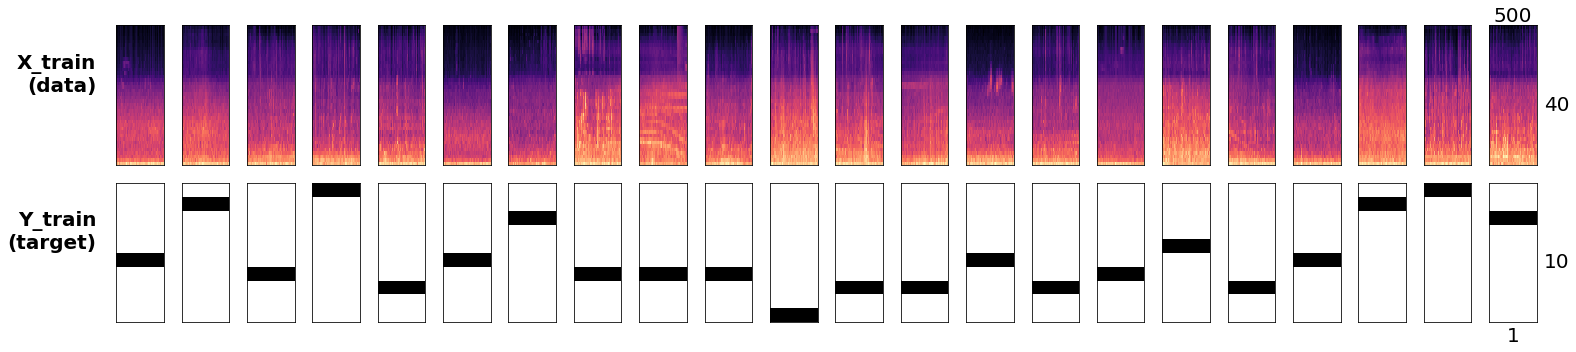

In [23]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 22, replace=False)
fig, axes = plt.subplots(2, len(example_ids), figsize=(22, 5))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.00, wspace=0.00)
for i, id in enumerate(example_ids):
    current_x = X_train[id,:,:]
    current_y = Y_train[id,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(numpy.expand_dims(current_y,-1)).plot(plot=False)
    #axes[1, i].set_xlabel(str(id), fontsize=20)
    #axes[0, i].get_xaxis().set_visible(False)
    #axes[1, i].get_xaxis().set_visible(False)
    
    #axes[0, i].get_yaxis().set_visible(False)
    #axes[1, i].get_yaxis().set_visible(False)
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('40', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('500',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('10', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('1',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

#axes[0, i].yaxis.label.set_visible(True)
#axes[1, i].yaxis.label.set_visible(True)
plt.tight_layout()

# Neural network structure

Next we create neural network structure layer by layer.


**Input** layer:

In [101]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands

In [102]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)

**Reshaping** layer to add channel axis into input data:

In [103]:
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)

In [104]:
print('Output shape','(sequence, frequency, time, channel)', x._keras_shape)

Output shape (sequence, frequency, time, channel) (None, 40, 500, 1)


Two convolutional **layer groups** consisting of:

1) **Convolution** to capture context and to extract high-level features: <br>*kernel 5x5 and filters 64*

In [105]:
x = Conv2D(
    filters=64, 
    kernel_size=(5, 5), 
    activation='linear', 
    padding='same', 
    data_format='channels_last',
    name='Conv1'
)(x)

2) **Batch normalization** to enable higher learning rates

In [106]:
x = BatchNormalization(
    axis=-1, 
    name='Conv1_BatchNorm'
)(x)

3) **Activation** (ReLu) to introduce non-linearity

In [107]:
x = Activation(
    activation='relu', name='Conv1_Activation'
)(x)

4) **Pooling** (2D) to extract dominant features<br>*pooling along both time and frequency*

In [108]:
x = MaxPooling2D(
    pool_size=(2, 4), name='Conv1_Pooling'
)(x)

5) **Dropout** to avoid overfitting

In [109]:
x = Dropout(
    rate=0.2, name='Conv1_DropOut'
)(x)

In [110]:
print('Output shape of CNN group 1','(sequence, frequency, time, feature)', x._keras_shape)

Output shape of CNN group 1 (sequence, frequency, time, feature) (None, 20, 125, 64)


Second convolutional layer:

In [111]:
x = Conv2D(filters=64, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_last', name='Conv2')(x)
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
x = Activation(activation='relu', name='Conv2_Activation')(x)
x = MaxPooling2D(pool_size=(2, 2), name='Conv2_Pooling')(x)
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)

In [112]:
print('Output shape of CNN group 2','(sequence, frequency, time, feature)', x._keras_shape)

Output shape of CNN group 2 (sequence, frequency, time, feature) (None, 10, 62, 64)


**Global max pooling** is applied to output of the last convolutional layer group to summarize output into a **single vector**:

In [113]:
x = GlobalMaxPooling2D(
    data_format='channels_last', 
    name='GlobalPooling'
)(x)


In [114]:
print('Output shape','(sequence, feature)', x._keras_shape)

Output shape (sequence, feature) (None, 64)


**Output layer** as fully-connected layer with a softmax activation:

In [115]:
output_layer = Dense(
    units=len(db.scene_labels()), 
    activation='softmax', 
    name='Output'
)(x)


In [116]:
print('Output shape','(sequence, class)', output_layer._keras_shape)

Output shape (sequence, class) (None, 10)


Create a model network:

In [117]:
model = Model(inputs=input_layer, outputs=output_layer)

## Model summary

In [100]:
dcase_util.keras.model_summary_string(
    keras_model=model,
    mode='extended', 
    show_parameters=False, 
    display=True
) # alternative for print(model.summary()) to get html table

Layer name,Layer type,Output shape,Parameters
Input,InputLayer,"(None, 40, 500)",0
Input_Reshape,Reshape,"(None, 40, 500, 1)",0
Conv1,Conv2D,"(None, 40, 500, 64)",1664
Conv1_BatchNorm,BatchNorm,"(None, 40, 500, 64)",256
Conv1_Activation,Activation,"(None, 40, 500, 64)",0
Conv1_Pooling,MaxPooling2D,"(None, 20, 125, 64)",0
Conv1_DropOut,Dropout,"(None, 20, 125, 64)",0
Conv2,Conv2D,"(None, 20, 125, 64)",102464
Conv2_BatchNorm,BatchNorm,"(None, 20, 125, 64)",256
Conv2_Activation,Activation,"(None, 20, 125, 64)",0


## Training

Key parameters:

- **Loss** &ndash; function used to measure difference between target and prediction <br> `categorical_crossentropy`
- **Metric** &ndash; evaluated for training and validation data during the learning process<br> `categorical_accuracy`
- **Optimizer** &ndash; function used to update model to minimize the loss
- **Learning rate** &ndash; how much model parameters are updated at each step
- **Batch size** &ndash; how many learning examples are processed before updating model parameters
- **Epochs** &ndash; how many times all learning data is gone through during the trainig procedure

In [34]:
callback_list=[
    dcase_util.keras.ProgressLoggerCallback(
        epochs=100, 
        metric='categorical_accuracy', 
        loss='categorical_crossentropy', 
        output_type='console', 
        show_timing=False,
    ),
    dcase_util.keras.StasherCallback(
        epochs=100, 
        monitor='val_categorical_accuracy'
    )
]

Compile the model:

In [35]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
    optimizer=keras.optimizers.Adam(lr=0.001, decay=0.001)
)

Start learning process:

In [36]:
history = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_validation, Y_validation),
    callbacks=callback_list,
    verbose=0,
    epochs=100,
    batch_size=16
)

  Training
            Loss                                Metric                             
            categorical_crossentropy            categorical_accuracy               
  Epoch     Train             Val               Train             Val              
  -------   ---------------   ---------------   ---------------   ---------------  
  1         1.4551            4.1296            0.4652            0.1474           
  2         1.3184            3.4960            0.5123            0.1469           
  3         1.2177            1.3006            0.5462            0.5307           
  4         1.1497            1.7890            0.5728            0.3556           
  5         1.0979            2.6919            0.6006            0.2862           
  6         1.0540            2.0941            0.6127            0.2254           
  7         1.0148            1.3386            0.6367            0.4864           
  8         0.9828            1.1452            0.6483           

## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [37]:
for callback in callback_list:
    if isinstance(callback, dcase_util.keras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [38]:
# Save model
model.save(model_filename)

# Save training history
dcase_util.files.Serializer().save_cpickle(filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'), data=history.history)

## Training history

In [3]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'))

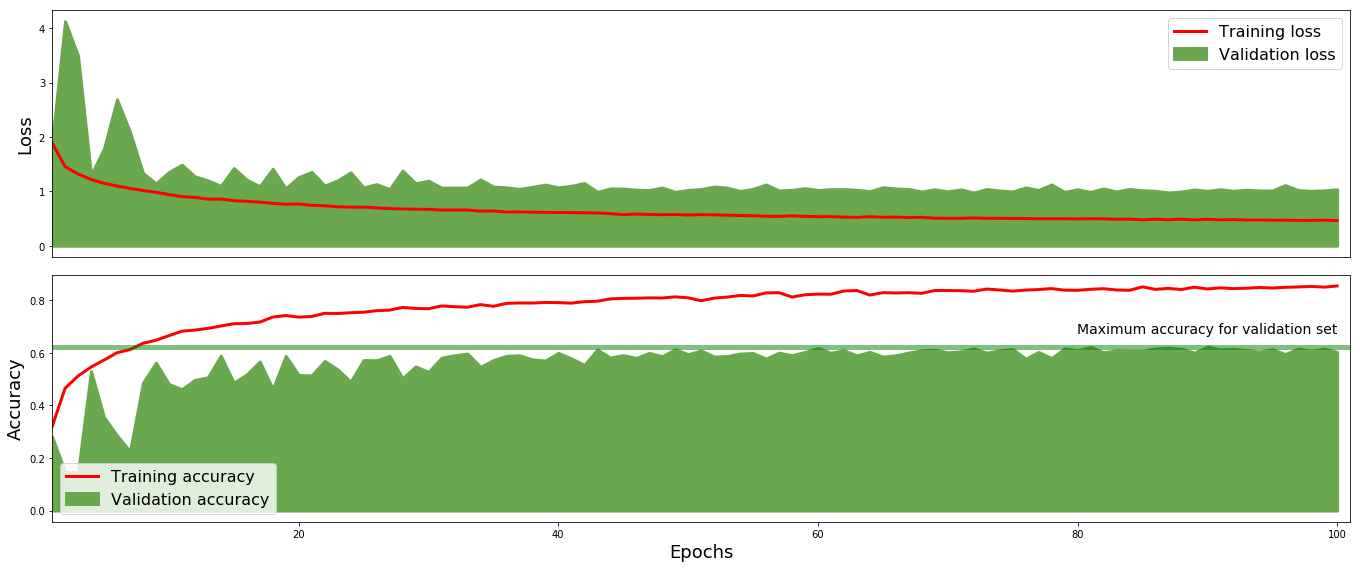

In [13]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))
plt.subplot(2,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
#plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.get_xaxis().set_visible(False)
panel.set_xlim([1,len(hist['loss']) + 1])

plt.subplot(2,1,2)
plt.plot(epochs, hist['categorical_accuracy'], color='red', linewidth=3, label='Training accuracy')
#plt.plot(epochs, hist['val_categorical_accuracy'], color='green', linewidth=3, label='Validation accuracy')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_categorical_accuracy'])), color='#6aa84f', linewidth=3, label='Validation accuracy')

acc_min_index = numpy.argmax(hist['val_categorical_accuracy'])
plt.axhline(hist['val_categorical_accuracy'][acc_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5)
plt.annotate('Maximum accuracy for validation set', xy=(len(hist['loss']),hist['val_categorical_accuracy'][acc_min_index]+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

# Testing stage

In [41]:
model = keras.models.load_model(model_filename) # Load model

**Extract** features for test item:

In [42]:
item = db.test(fold=1)[0]
features = mel_extractor.extract(
    AudioContainer().load(filename=item.filename, mono=True)
)[:,:sequence_length]

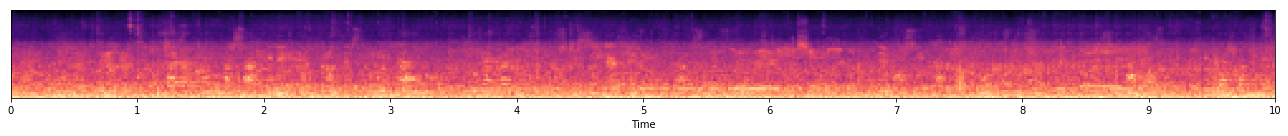

In [43]:
dcase_util.containers.FeatureContainer(features, time_resolution=0.02).plot(figsize=(18,2))

**Reshape** the matrix to match model input:

In [44]:
input_data = numpy.expand_dims(features, 0)

In [45]:
print('input_data shape', '(sequence, frequency, time)', input_data.shape)

input_data shape (sequence, frequency, time) (1, 40, 500)


Feed input data into model to get **probabilities for each scene class**:

In [46]:
probabilities = model.predict(x=input_data)
probabilities

array([[7.9669255e-01, 1.1163409e-03, 5.5917713e-04, 1.9114263e-02,
        1.0737061e-04, 5.2536655e-02, 4.5423049e-02, 7.8112699e-02,
        1.9047990e-04, 6.1474713e-03]], dtype=float32)

**Classify** by selecting class giving **maximum output**:

In [47]:
frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
    probabilities=probabilities.T,
    binarization_type='frame_max'
).T  
frame_decisions

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Scene label:

In [48]:
scene_labels[numpy.argmax(frame_decisions)]


'airport'

## Going through all test material

In [50]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_asc.csv'))

for item in db.test(fold=1):
    print('Test', db.absolute_to_relative_path(item.filename))
    # Load features
    features = get_feature_matrix(item.filename)[:,:sequence_length]
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename, mono=True)
    #)[:,:sequence_length]
    input_data = numpy.expand_dims(features, 0)

    # Get network output
    probabilities = model.predict(x=input_data)

    # Binarization and getting estimated scene label
    frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=probabilities.T,
        binarization_type='frame_max'
    )   
    estimated_scene_label = scene_labels[numpy.argmax(frame_decisions)]
    
    # Store result into results container
    res.append(
        {
            'filename': item.filename,
            'scene_label': estimated_scene_label
        }
    )
    
# Save results container
res.save().show()

Test audio/airport-barcelona-203-6122-a.wav
Test audio/airport-barcelona-203-6123-a.wav
Test audio/airport-barcelona-203-6124-a.wav
Test audio/airport-barcelona-203-6125-a.wav
Test audio/airport-barcelona-203-6126-a.wav
Test audio/airport-barcelona-203-6127-a.wav
Test audio/airport-barcelona-203-6128-a.wav
Test audio/airport-barcelona-203-6129-a.wav
Test audio/airport-barcelona-203-6130-a.wav
Test audio/airport-barcelona-203-6131-a.wav
Test audio/airport-barcelona-203-6132-a.wav
Test audio/airport-barcelona-203-6133-a.wav
Test audio/airport-barcelona-203-6134-a.wav
Test audio/airport-barcelona-203-6135-a.wav
Test audio/airport-barcelona-203-6136-a.wav
Test audio/airport-barcelona-203-6137-a.wav
Test audio/airport-helsinki-204-6138-a.wav
Test audio/airport-helsinki-204-6139-a.wav
Test audio/airport-helsinki-204-6140-a.wav
Test audio/airport-helsinki-204-6141-a.wav
Test audio/airport-helsinki-204-6142-a.wav
Test audio/airport-helsinki-204-6143-a.wav
Test audio/airport-helsinki-204-6144-a

Test audio/bus-paris-215-6523-a.wav
Test audio/bus-paris-215-6524-a.wav
Test audio/bus-paris-215-6525-a.wav
Test audio/bus-paris-215-6526-a.wav
Test audio/bus-paris-215-6527-a.wav
Test audio/bus-paris-215-6528-a.wav
Test audio/bus-paris-215-6529-a.wav
Test audio/bus-paris-215-6530-a.wav
Test audio/bus-paris-215-6531-a.wav
Test audio/bus-paris-215-6532-a.wav
Test audio/bus-paris-216-6533-a.wav
Test audio/bus-paris-216-6534-a.wav
Test audio/bus-paris-216-6535-a.wav
Test audio/bus-paris-216-6536-a.wav
Test audio/bus-paris-216-6537-a.wav
Test audio/bus-paris-216-6538-a.wav
Test audio/bus-paris-216-6539-a.wav
Test audio/bus-paris-216-6540-a.wav
Test audio/bus-paris-216-6541-a.wav
Test audio/bus-paris-216-6542-a.wav
Test audio/bus-paris-216-6543-a.wav
Test audio/bus-paris-216-6544-a.wav
Test audio/bus-stockholm-217-6545-a.wav
Test audio/bus-stockholm-217-6546-a.wav
Test audio/bus-stockholm-217-6547-a.wav
Test audio/bus-stockholm-217-6548-a.wav
Test audio/bus-stockholm-217-6549-a.wav
Test aud

Test audio/metro_station-barcelona-230-6924-a.wav
Test audio/metro_station-barcelona-230-6925-a.wav
Test audio/metro_station-barcelona-230-6926-a.wav
Test audio/metro_station-barcelona-230-6927-a.wav
Test audio/metro_station-barcelona-230-6928-a.wav
Test audio/metro_station-barcelona-230-6929-a.wav
Test audio/metro_station-barcelona-230-6930-a.wav
Test audio/metro_station-barcelona-230-6931-a.wav
Test audio/metro_station-barcelona-230-6932-a.wav
Test audio/metro_station-barcelona-230-6933-a.wav
Test audio/metro_station-barcelona-230-6934-a.wav
Test audio/metro_station-barcelona-230-6935-a.wav
Test audio/metro_station-barcelona-230-6936-a.wav
Test audio/metro_station-barcelona-230-6937-a.wav
Test audio/metro_station-barcelona-230-6938-a.wav
Test audio/metro_station-barcelona-230-6939-a.wav
Test audio/metro_station-barcelona-230-6940-a.wav
Test audio/metro_station-barcelona-230-6941-a.wav
Test audio/metro_station-barcelona-230-6942-a.wav
Test audio/metro_station-barcelona-230-6943-a.wav


Test audio/park-paris-244-7290-a.wav
Test audio/park-paris-244-7291-a.wav
Test audio/park-paris-244-7292-a.wav
Test audio/park-paris-244-7293-a.wav
Test audio/park-paris-244-7294-a.wav
Test audio/park-paris-244-7295-a.wav
Test audio/park-paris-244-7296-a.wav
Test audio/park-paris-244-7297-a.wav
Test audio/park-stockholm-245-7298-a.wav
Test audio/park-stockholm-245-7299-a.wav
Test audio/park-stockholm-245-7300-a.wav
Test audio/park-stockholm-245-7301-a.wav
Test audio/park-stockholm-245-7302-a.wav
Test audio/park-stockholm-245-7303-a.wav
Test audio/park-stockholm-245-7304-a.wav
Test audio/park-stockholm-245-7305-a.wav
Test audio/park-stockholm-245-7306-a.wav
Test audio/park-stockholm-245-7307-a.wav
Test audio/park-stockholm-245-7308-a.wav
Test audio/park-stockholm-245-7309-a.wav
Test audio/park-stockholm-245-7310-a.wav
Test audio/park-stockholm-245-7311-a.wav
Test audio/park-stockholm-245-7312-a.wav
Test audio/park-stockholm-245-7313-a.wav
Test audio/park-stockholm-245-7314-a.wav
Test au

Test audio/shopping_mall-helsinki-255-7646-a.wav
Test audio/shopping_mall-helsinki-255-7647-a.wav
Test audio/shopping_mall-helsinki-255-7648-a.wav
Test audio/shopping_mall-helsinki-255-7649-a.wav
Test audio/shopping_mall-helsinki-255-7650-a.wav
Test audio/shopping_mall-helsinki-255-7651-a.wav
Test audio/shopping_mall-helsinki-255-7652-a.wav
Test audio/shopping_mall-helsinki-255-7653-a.wav
Test audio/shopping_mall-helsinki-255-7654-a.wav
Test audio/shopping_mall-helsinki-255-7655-a.wav
Test audio/shopping_mall-helsinki-255-7656-a.wav
Test audio/shopping_mall-helsinki-255-7657-a.wav
Test audio/shopping_mall-helsinki-255-7658-a.wav
Test audio/shopping_mall-helsinki-255-7659-a.wav
Test audio/shopping_mall-helsinki-255-7660-a.wav
Test audio/shopping_mall-helsinki-255-7661-a.wav
Test audio/shopping_mall-helsinki-255-7662-a.wav
Test audio/shopping_mall-helsinki-255-7663-a.wav
Test audio/shopping_mall-helsinki-255-7664-a.wav
Test audio/shopping_mall-helsinki-255-7665-a.wav
Test audio/shopping_

Test audio/street_pedestrian-london-263-7979-a.wav
Test audio/street_pedestrian-london-263-7980-a.wav
Test audio/street_pedestrian-london-263-7981-a.wav
Test audio/street_pedestrian-london-263-7982-a.wav
Test audio/street_pedestrian-london-263-7983-a.wav
Test audio/street_pedestrian-london-263-7984-a.wav
Test audio/street_pedestrian-london-263-7985-a.wav
Test audio/street_pedestrian-london-263-7986-a.wav
Test audio/street_pedestrian-london-263-7987-a.wav
Test audio/street_pedestrian-london-263-7988-a.wav
Test audio/street_pedestrian-london-263-7989-a.wav
Test audio/street_pedestrian-london-263-7990-a.wav
Test audio/street_pedestrian-london-263-7991-a.wav
Test audio/street_pedestrian-london-263-7992-a.wav
Test audio/street_pedestrian-london-263-7993-a.wav
Test audio/street_pedestrian-london-263-7994-a.wav
Test audio/street_pedestrian-london-263-7995-a.wav
Test audio/street_pedestrian-london-263-7996-a.wav
Test audio/street_pedestrian-london-263-7997-a.wav
Test audio/street_pedestrian-lo

Test audio/street_traffic-paris-272-8305-a.wav
Test audio/street_traffic-paris-272-8306-a.wav
Test audio/street_traffic-stockholm-273-8307-a.wav
Test audio/street_traffic-stockholm-273-8308-a.wav
Test audio/street_traffic-stockholm-273-8309-a.wav
Test audio/street_traffic-stockholm-273-8310-a.wav
Test audio/street_traffic-stockholm-273-8311-a.wav
Test audio/street_traffic-stockholm-273-8312-a.wav
Test audio/street_traffic-stockholm-273-8313-a.wav
Test audio/street_traffic-stockholm-273-8314-a.wav
Test audio/street_traffic-stockholm-273-8315-a.wav
Test audio/street_traffic-stockholm-273-8316-a.wav
Test audio/street_traffic-stockholm-273-8317-a.wav
Test audio/street_traffic-stockholm-273-8318-a.wav
Test audio/street_traffic-stockholm-273-8319-a.wav
Test audio/street_traffic-stockholm-273-8320-a.wav
Test audio/street_traffic-stockholm-273-8321-a.wav
Test audio/street_traffic-stockholm-273-8322-a.wav
Test audio/street_traffic-stockholm-273-8323-a.wav
Test audio/street_traffic-stockholm-273

Scene label,Count,Identifiers
airport,435,0
bus,293,0
metro,177,0
metro_station,199,0
park,242,0
public_square,270,0
shopping_mall,164,0
street_pedestrian,210,0
street_traffic,214,0
tram,314,0


# Evaluation

## Preparing data for evaluation

In [52]:
# Load reference and system output
reference_scene_list = db.eval(fold=1)
estimated_scene_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_asc.csv')
).load()
# Collect test items into lists in same order
y_true = []
y_pred = []
for item_id, item in enumerate(reference_scene_list):
    y_true.append(item.scene_label)
    for item_estimated in estimated_scene_list:
        if os.path.split(item_estimated.filename)[-1] == os.path.split(item.filename)[-1]:
            y_pred.append(item_estimated.scene_label)
            break

## Calculating metric

In [53]:
# Get confusion matrix with counts
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

# Transform matrix into percentages, normalize row-wise
conf = confusion_matrix * 100.0 / confusion_matrix.sum(axis=1)[:, numpy.newaxis]  

# Fetch class-wise accuracies from diagonal
class_wise_accuracies = numpy.diag(conf)                

# Calculate overall accuracy
numpy.mean(class_wise_accuracies)


59.417502980063

## Class-wise accuracies

In [56]:
labels = db.scene_labels()
labels.append('Average')
values = class_wise_accuracies
values = numpy.append(values, numpy.mean(class_wise_accuracies))
log.table(
    cell_data=[
        labels,values
    ],
    column_headers=['Scene label', 'Accuracy'],
    column_types=['str30', 'float1'],
    row_separators=[10],
    scaling=120,
)

Scene label,Accuracy
airport,74.7
bus,65.3
metro,48.3
metro_station,54.4
park,82.6
public_square,48.6
shopping_mall,46.6
street_pedestrian,43.3
street_traffic,73.6
tram,56.7


## Confusion matrix

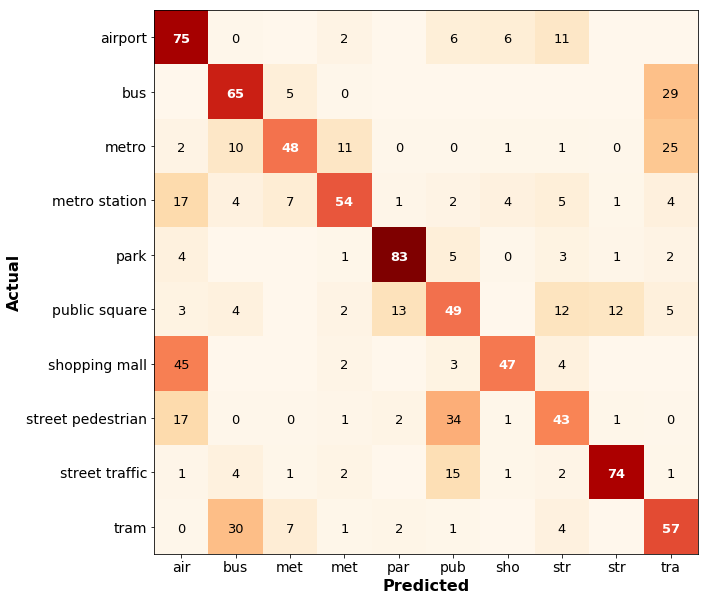

In [57]:
fig = plt.figure(figsize=(10,10))    
plt.imshow(conf, cmap=plt.cm.OrRd)
labels = []
labels_short = []
for label in db.scene_labels():
    labels.append(str(label.replace('_', ' ')))
    labels_short.append(label[0:3])    
plt.yticks(range(len(scene_labels)), labels, fontsize=14)
plt.xticks(range(len(scene_labels)), labels_short, fontsize=14)
plt.ylabel('Actual', fontsize=16, fontweight="bold")
plt.xlabel('Predicted', fontsize=16, fontweight="bold")
for x in range(len(scene_labels)):
    for y in range(len(scene_labels)):
        if conf[y, x] > 0:
            plt.text(x, y + 0.1, "{:.0f}".format(conf[y, x]), 
                     fontsize=13, ha='center', 
                     color= 'white' if (x==y) else 'black', 
                     weight= 'bold' if (x==y) else 'normal')          

## Confidence interval for the accuracy

In [58]:
from statsmodels.stats import proportion
Nref = len(y_true)
Ncorr = numpy.sum(numpy.diag(confusion_matrix))
ci95 = proportion.proportion_confint(
    count=Ncorr,
    nobs=Nref,
    alpha=0.05,
    method='normal'
)
log.data('95% confidence interval', '{0:2.2f} - {1:2.2f}'.format(ci95[0]*100, ci95[1]*100))